In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 91.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zjr_path = '/content/drive/MyDrive/AI4EO/final/zhujiang/S2A_MSIL2A_20250415T030151_N0511_R032_T49QGF_20250415T095813.SAFE/GRANULE/L2A_T49QGF_A051252_20250415T030753/IMG_DATA/'
yzr_path ='/content/drive/MyDrive/AI4EO/final/yamgzijiamg/S2B_MSIL2A_20250512T023529_N0511_R089_T51RTQ_20250512T043829.SAFE/GRANULE/L2A_T51RTQ_A042729_20250512T024549/IMG_DATA/'

#Zhujiang NDWI

In [18]:
import rasterio
import numpy as np

# Specify file paths to the bands being used
zjr_bands_paths = {
    'B8': zjr_path + 'R10m/T49QGF_20250415T030151_B08_10m.jp2',
    'B3': zjr_path + 'R10m/T49QGF_20250415T030151_B03_10m.jp2',
}

# Read and stack the band images
zjr_band_data = []
for band in ['B3', 'B8']:
    with rasterio.open(zjr_bands_paths[band]) as src:
        zjr_band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
zjr_band_stack = np.dstack(zjr_band_data)
zjr_valid_data_mask = np.all(zjr_band_stack > 0, axis=2)


# Calculating the NDWI
zjr_green_band = zjr_band_stack[:,:,0].astype(np.float16)
zjr_nir_band = zjr_band_stack[:,:,1].astype(np.float16)

zjr_ndwi = (zjr_green_band-zjr_nir_band)/(zjr_green_band+zjr_nir_band)

# Thresholding the NDWI
threshold = 0.0 # Threshold value
zjr_mask_ndwi = np.where(zjr_ndwi > threshold, 1, 0).astype(np.uint8)

<ipython-input-18-a5d3c7a0a570>:25: RuntimeWarning: invalid value encountered in divide
  zjr_ndwi = (zjr_green_band-zjr_nir_band)/(zjr_green_band+zjr_nir_band)


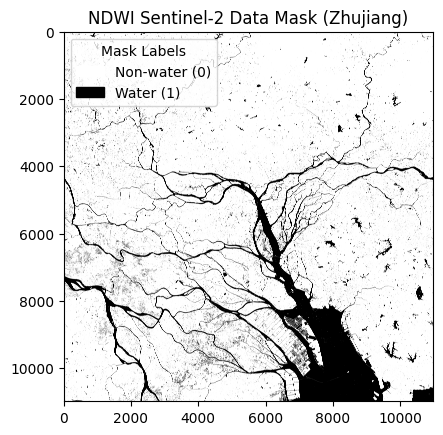

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Create legend
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0)),  # Patch for color at vmin
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.99)),  # Patch for color at vmax
]
labels = ['Non-water (0)', 'Water (1)']
plt.legend(patches, labels, loc='upper left', title='Mask Labels')


# Plotting the result
plt.imshow(zjr_mask_ndwi, cmap='binary')
plt.title('NDWI Sentinel-2 Data Mask (Zhujiang)')
plt.show()

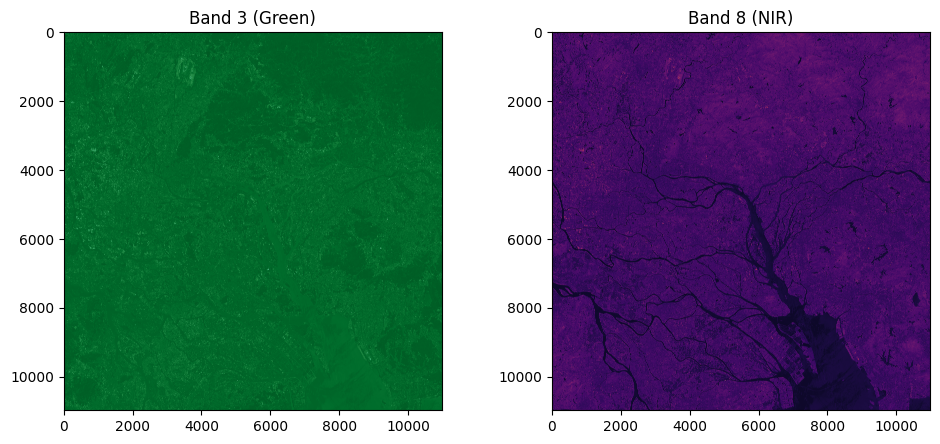

In [7]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Specify file paths to the bands being used
zjr_bands_paths = {
    'B8': zjr_path + 'R10m/T49QGF_20250415T030151_B08_10m.jp2',
    'B3': zjr_path + 'R10m/T49QGF_20250415T030151_B03_10m.jp2',
}


# Read and stack the band images
zjr_band_data = []
for band in ['B3', 'B8']:
    with rasterio.open(zjr_bands_paths[band]) as src:
        zjr_band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
zjr_band_stack = np.dstack(zjr_band_data)
zjr_valid_data_mask = np.all(zjr_band_stack > 0, axis=2)

# Visual Plot of Bands

fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

ax1.imshow(zjr_band_stack[:,:,0], cmap='BuGn_r')  # Plot on the first subplot (ax1)
ax1.set_title('Band 3 (Green)')

ax2.imshow(zjr_band_stack[:,:,1], cmap= 'inferno')  # Plot on the second subplot (ax2)
ax2.set_title('Band 8 (NIR)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()

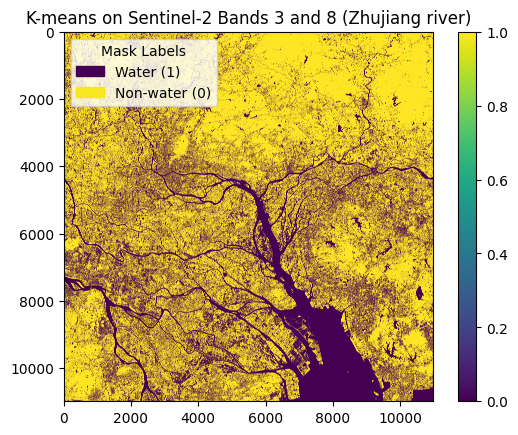

In [24]:
# Reshape for K-means, only including valid data
zjrX = zjr_band_stack[zjr_valid_data_mask].reshape((-1, 2))

# K-means clustering
zjr_kmeans = KMeans(n_clusters=2, random_state=0).fit(zjrX)
zjr_labels = zjr_kmeans.labels_

# Create an empty array for the result, filled with a no-data value (e.g., -1)
zjr_labels_image_traditional = np.full(zjr_band_stack.shape[:2], -1, dtype=int)

# Place cluster labels in the locations corresponding to valid data
zjr_labels_image_traditional[zjr_valid_data_mask] = zjr_labels

band8 = zjr_band_stack[:, :, 1]
mean_b8_cluster0 = band8[zjr_labels_image_traditional == 0].mean()
mean_b8_cluster1 = band8[zjr_labels_image_traditional == 1].mean()

# 水体近红外反射率低，所以平均值小
if mean_b8_cluster0 > mean_b8_cluster1:
    zjr_labels = 1 - zjr_labels  # 翻转标签
    zjr_labels_image_traditional[zjr_valid_data_mask] = zjr_labels
# --------------------------------

# Create legend
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0)),    # Water (0)
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.99))  # Non-water (1)
]
labels = ['Water (1)', 'Non-water (0)']
plt.legend(patches, labels, loc='upper left', title='Mask Labels')

# Displaying Image
plt.imshow(zjr_labels_image_traditional, cmap='viridis', vmin=0, vmax=1)
plt.title('K-means on Sentinel-2 Bands 3 and 8 (Zhujiang river)')
plt.colorbar()
plt.show()


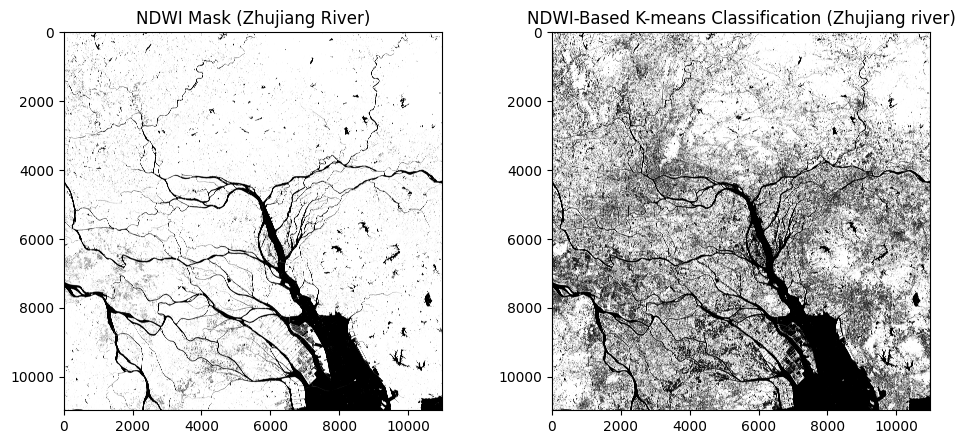

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# NDWI 掩码
ax1.imshow(zjr_mask_ndwi, cmap='binary', vmin=0, vmax=1)
ax1.set_title('NDWI Mask (Zhujiang River)')

# 清洗和翻转标签
zjr_labels_cleaned = np.where(zjr_labels_image_traditional == 1, 1, 0)
zjr_labels_cleaned = 1 - zjr_labels_cleaned  # <== 翻转标签：1表示水体

# K-means 结果图
ax2.imshow(zjr_labels_cleaned, cmap='binary', vmin=0, vmax=1)
ax2.set_title('NDWI-Based K-means Classification (Zhujiang river)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()


In [12]:
ndwi_baseline_flat = zjr_mask_ndwi.flatten()
kmeans_pred_flat   = zjr_labels_image_traditional.flatten()


valid_mask = np.isin(ndwi_baseline_flat, [0, 1]) & np.isin(kmeans_pred_flat, [0, 1])


ndwi_baseline_valid = ndwi_baseline_flat[valid_mask]
kmeans_pred_valid = kmeans_pred_flat[valid_mask]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.26      0.37 106424508
           1       0.01      0.04      0.01  14135888

    accuracy                           0.23 120560396
   macro avg       0.34      0.15      0.19 120560396
weighted avg       0.59      0.23      0.33 120560396



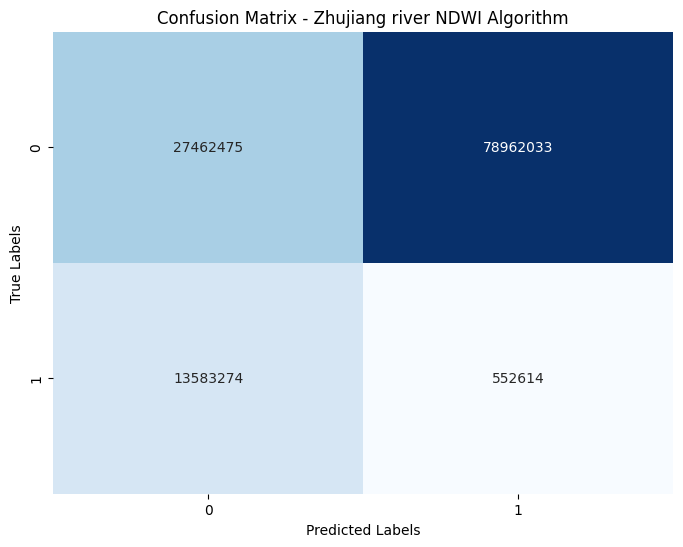

Accuracy: 0.23


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import cv2

## Data preprocessing ##

# Retrieval of values from NDWI mask (1 = water, 0 = land)
mask_ndwi = zjr_mask_ndwi

# Retrieval of values from K-means mask (1 = water, 0 = land, -1 = no data)
kmeans_results = zjr_labels_image_traditional

## Analysis calculations ##

# Flatten the 2D arrays
ndwi_baseline = mask_ndwi.flatten()
kmeans_pred   = kmeans_results.flatten()

# ✅ 添加：创建掩码，排除无效像素（-1）
valid_mask = np.isin(ndwi_baseline, [0, 1]) & np.isin(kmeans_pred, [0, 1])
ndwi_baseline_valid = ndwi_baseline[valid_mask]
kmeans_pred_valid   = kmeans_pred[valid_mask]

# Compute confusion matrix
cm = confusion_matrix(ndwi_baseline_valid, kmeans_pred_valid)

# Calculate accuracy
accuracy = accuracy_score(ndwi_baseline_valid, kmeans_pred_valid)

# Display classification report
report = classification_report(ndwi_baseline_valid, kmeans_pred_valid)
print("Classification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Zhujiang river NDWI Algorithm")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display accuracy
print(f"Accuracy: {accuracy:.2f}")


#Zhujiang River MNDWI

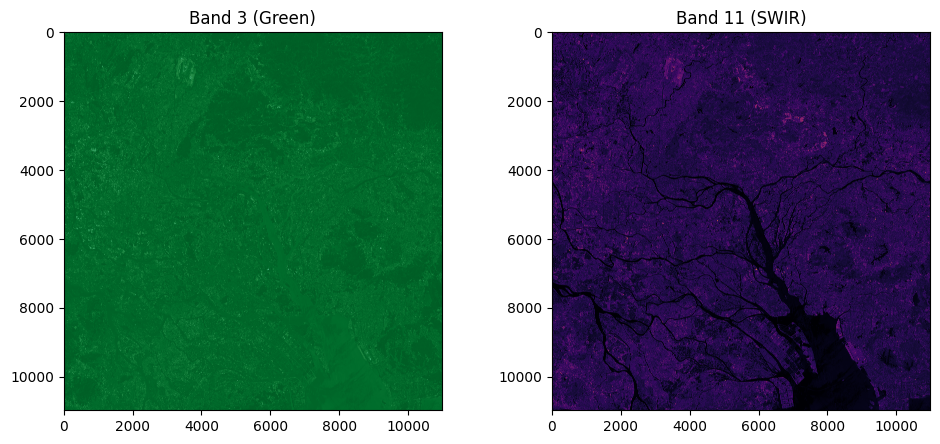

In [17]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from rasterio.enums import Resampling

zjr_bands_paths = {
    'B3': zjr_path + 'R10m/T49QGF_20250415T030151_B03_10m.jp2',   # 10m
    'B11': zjr_path + 'R20m/T49QGF_20250415T030151_B11_20m.jp2'   # 20m
}

zjr_band_data2 = []

# Open B3 (10m) first and get shape and profile
with rasterio.open(zjr_bands_paths['B3']) as src_b3:
    b3 = src_b3.read(1)
    ref_shape = b3.shape  # (height, width)
    ref_transform = src_b3.transform
    ref_crs = src_b3.crs
    zjr_band_data.append(b3)

# Open B11 (20m) and resample to 10m using rasterio
with rasterio.open(zjr_bands_paths['B11']) as src_b11:
    b11_resampled = src_b11.read(
        1,
        out_shape=ref_shape,
        resampling=Resampling.bilinear
    )
    zjr_band_data.append(b11_resampled)

# Stack to form 3D array
zjr_band_stack = np.dstack(zjr_band_data)

# Create valid mask where both bands > 0
zjr_valid_data_mask = np.all(zjr_band_stack > 0, axis=2)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(zjr_band_stack[:,:,0], cmap='BuGn_r')
ax1.set_title('Band 3 (Green)')

ax2.imshow(zjr_band_stack[:,:,1], cmap='inferno')
ax2.set_title('Band 11 (SWIR)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()


[INFO] MNDWI median: class 0 = -0.2171, class 1 = 0.0926


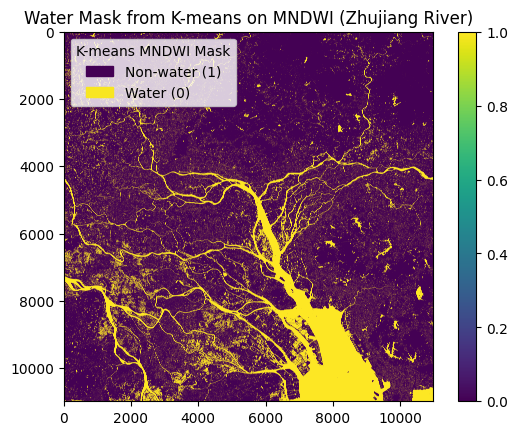

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle
import rasterio
from rasterio.enums import Resampling

# ===== 1. 读取并重采样波段（B3=Green, B11=SWIR） =====
zjr_bands_paths = {
    'B3': zjr_path + 'R10m/T49QGF_20250415T030151_B03_10m.jp2',   # Green
    'B11': zjr_path + 'R20m/T49QGF_20250415T030151_B11_20m.jp2'   # SWIR
}

with rasterio.open(zjr_bands_paths['B3']) as src:
    zjr_ref_shape = src.read(1).shape
    zjr_ref_transform = src.transform
    zjr_ref_crs = src.crs

zjr_band_data2 = []
for band_key in ['B3', 'B11']:
    with rasterio.open(zjr_bands_paths[band_key]) as src:
        zjr_band = src.read(
            1,
            out_shape=zjr_ref_shape,
            resampling=Resampling.bilinear
        )
        zjr_band_data2.append(zjr_band)

# ===== 2. 计算 MNDWI =====
zjr_green = zjr_band_data2[0] / 10000.0
zjr_swir  = zjr_band_data2[1] / 10000.0

zjr_mndwi_index = (zjr_green - zjr_swir) / (zjr_green + zjr_swir + 1e-6)
zjr_valid_mask_mndwi = (zjr_green > 0) & (zjr_swir > 0)

# ===== 3. K-means 聚类（基于 MNDWI）=====
zjr_mndwi_features = zjr_mndwi_index[zjr_valid_mask_mndwi].reshape(-1, 1)
zjr_kmeans_mndwi = KMeans(n_clusters=2, random_state=0).fit(zjr_mndwi_features)
zjr_labels_mndwi = zjr_kmeans_mndwi.labels_

zjr_labels_image_mndwi = np.full(zjr_mndwi_index.shape, -1, dtype=int)
zjr_labels_image_mndwi[zjr_valid_mask_mndwi] = zjr_labels_mndwi

# ===== ✅ 使用 median 判断水体类 =====
zjr_median_0 = np.median(zjr_mndwi_index[zjr_labels_image_mndwi == 0])
zjr_median_1 = np.median(zjr_mndwi_index[zjr_labels_image_mndwi == 1])

print(f"[INFO] MNDWI median: class 0 = {zjr_median_0:.4f}, class 1 = {zjr_median_1:.4f}")

if zjr_median_0 > zjr_median_1:
    zjr_water_mask_mndwi = (zjr_labels_image_mndwi == 0).astype(int)
else:
    zjr_water_mask_mndwi = (zjr_labels_image_mndwi == 1).astype(int)

# ===== 4. 可视化 =====
zjr_legend_patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0)),
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.99))
]
zjr_legend_labels = ['Non-water (1)', 'Water (0)']

plt.legend(zjr_legend_patches, zjr_legend_labels, loc='upper left', title='K-means MNDWI Mask')
plt.imshow(zjr_water_mask_mndwi, cmap='viridis', vmin=0, vmax=1)
plt.title('Water Mask from K-means on MNDWI (Zhujiang River)')
plt.colorbar()
plt.show()




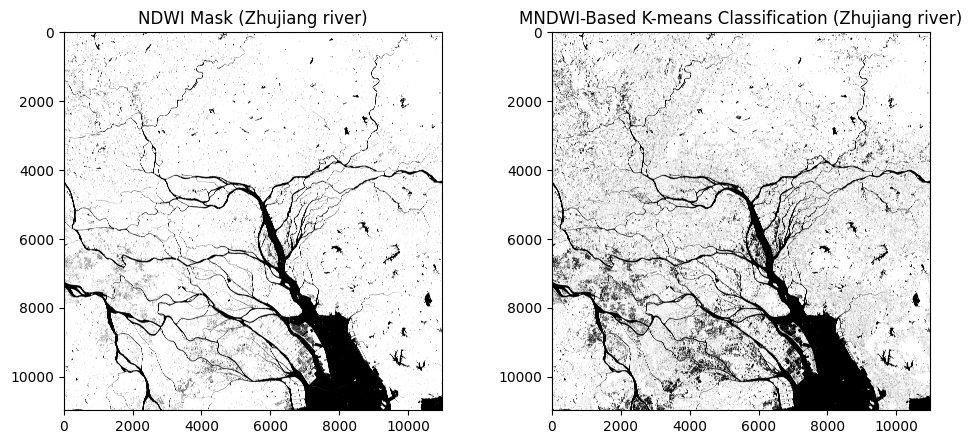

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

ax1.imshow(zjr_mask_ndwi, cmap='binary')  # Plot on the first subplot (ax1)
ax1.set_title('NDWI Mask (Zhujiang river)')

ax2.imshow(zjr_water_mask_mndwi, cmap= 'binary')  # Plot on the second subplot (ax2)
ax2.set_title('MNDWI-Based K-means Classification (Zhujiang river)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96 106424512
           1       0.62      0.97      0.75  14135888

    accuracy                           0.93 120560400
   macro avg       0.81      0.94      0.86 120560400
weighted avg       0.95      0.93      0.93 120560400



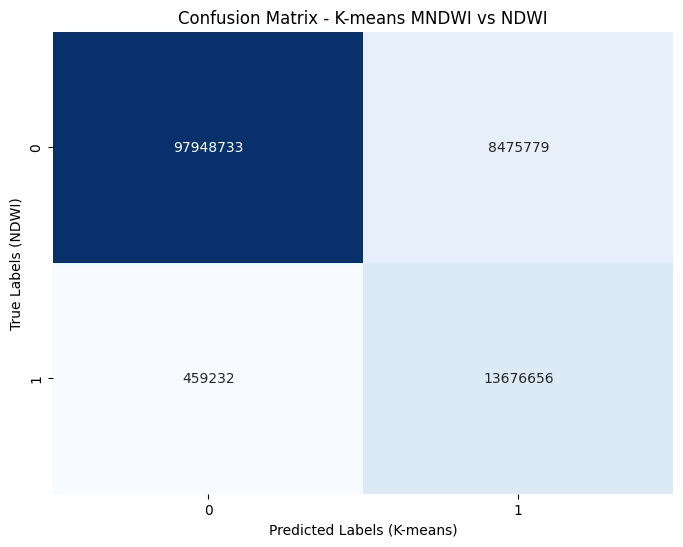

Accuracy: 0.93


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import cv2

## Data preprocessing ##

# Retrieval of values from NDWI mask (1 = water, 0 = land)
ndwi_baseline = zjr_mask_ndwi.flatten()  # 举例：你实际变量名


# Retrieval of values from K-means mask (1 = water, 0 = land or -1 = invalid)
kmeans_pred_raw = zjr_water_mask_mndwi.flatten()

# ===== ✅ 1. 保留只含 0 和 1 的有效像素 =====
valid_mask = np.isin(ndwi_baseline, [0, 1]) & np.isin(kmeans_pred_raw, [0, 1])
ndwi_valid = ndwi_baseline[valid_mask]
kmeans_valid = kmeans_pred_raw[valid_mask]

# ===== ✅ 2. 自动反转标签（使其与 NDWI 对齐：1=water） =====
# 如果标签反了（例如预测的水体大多数被标为 0），我们可以翻转标签
conf_mat = confusion_matrix(ndwi_valid, kmeans_valid)
acc_normal = np.trace(conf_mat) / np.sum(conf_mat)

# 尝试翻转预测标签
kmeans_flipped = 1 - kmeans_valid
conf_mat_flip = confusion_matrix(ndwi_valid, kmeans_flipped)
acc_flipped = np.trace(conf_mat_flip) / np.sum(conf_mat_flip)

# 如果翻转后准确率更高，说明标签反了 → 用翻转后的预测
if acc_flipped > acc_normal:
    kmeans_valid = kmeans_flipped
    print("[INFO] Labels were flipped to match NDWI definition (1 = water).")

# ===== 3. 输出评估指标 =====
cm = confusion_matrix(ndwi_valid, kmeans_valid)
accuracy = accuracy_score(ndwi_valid, kmeans_valid)
report = classification_report(ndwi_valid, kmeans_valid)

print("Classification Report:\n", report)

# ===== 4. 混淆矩阵可视化 =====
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - K-means MNDWI vs NDWI")
plt.xlabel("Predicted Labels (K-means)")
plt.ylabel("True Labels (NDWI)")
plt.show()

print(f"Accuracy: {accuracy:.2f}")

#Yangzi River NDWI


In [31]:
import rasterio
import numpy as np

# Specify file paths to the bands being used
yzr_bands_paths = {
    'B8': yzr_path + 'R10m/T51RTQ_20250512T023529_B08_10m.jp2',
    'B3': yzr_path + 'R10m/T51RTQ_20250512T023529_B03_10m.jp2',
}

# Read and stack the band images
yzr_band_data = []
for band in ['B3', 'B8']:
    with rasterio.open(yzr_bands_paths[band]) as src:
        yzr_band_data.append(src.read(1))

# Stack bands
yzr_band_stack = np.dstack(yzr_band_data)


# Calculating the NDWI
yzr_green_band = yzr_band_stack[:,:,0].astype(np.float16)
yzr_nir_band = yzr_band_stack[:,:,1].astype(np.float16)

yzr_ndwi = (yzr_green_band-yzr_nir_band)/(yzr_green_band+yzr_nir_band)

# Thresholding the NDWI
threshold = 0.0 # Threshold value
yzr_mask_ndwi = np.where(yzr_ndwi > threshold, 1, 0).astype(np.uint8)

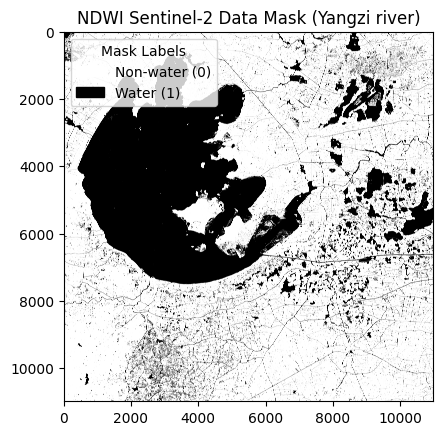

In [32]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Create legend
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0)),  # Patch for color at vmin
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.99)),  # Patch for color at vmax
]
labels = ['Non-water (0)', 'Water (1)']
plt.legend(patches, labels, loc='upper left', title='Mask Labels')

# Plotting the result
plt.imshow(yzr_mask_ndwi, cmap='binary')
plt.title('NDWI Sentinel-2 Data Mask (Yangzi river)')
plt.show()

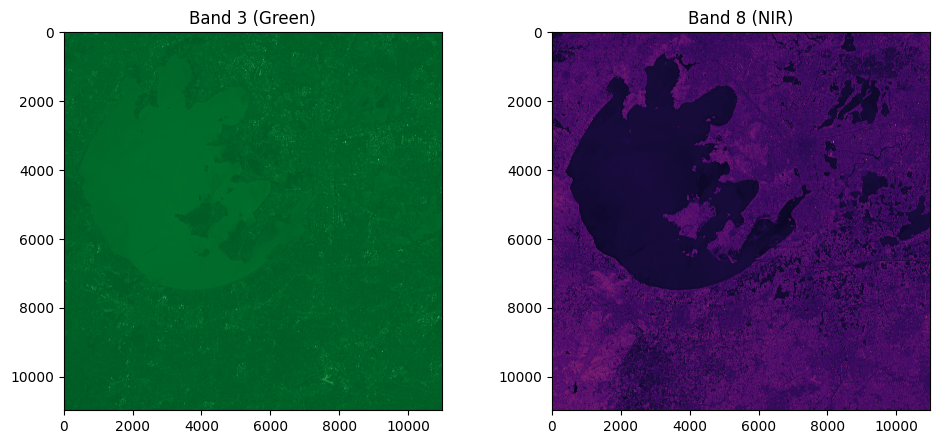

In [28]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Specify file paths to the bands being used
yzr_bands_paths = {
    'B8': yzr_path + 'R10m/T51RTQ_20250512T023529_B08_10m.jp2',
    'B3': yzr_path + 'R10m/T51RTQ_20250512T023529_B03_10m.jp2',
}

# Read and stack the band images
yzr_band_data = []
for band in ['B3', 'B8']:
    with rasterio.open(yzr_bands_paths[band]) as src:
        yzr_band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
yzr_band_stack = np.dstack(yzr_band_data)
yzr_valid_data_mask = np.all(yzr_band_stack > 0, axis=2)

# Visual Plot of Bands

fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

ax1.imshow(yzr_band_stack[:,:,0], cmap='BuGn_r')  # Plot on the first subplot (ax1)
ax1.set_title('Band 3 (Green)')

ax2.imshow(yzr_band_stack[:,:,1], cmap= 'inferno')  # Plot on the second subplot (ax2)
ax2.set_title('Band 8 (NIR)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()

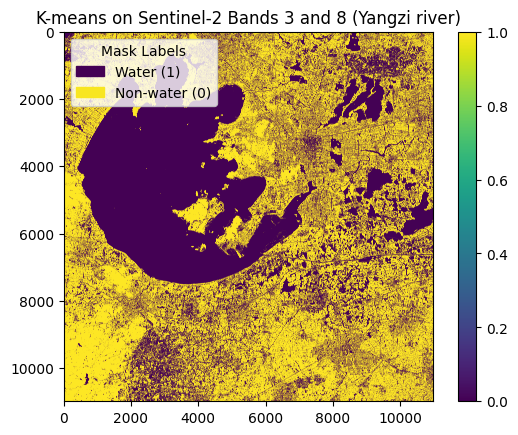

In [34]:
# Reshape for K-means, only including valid data
yzrX = yzr_band_stack[yzr_valid_data_mask].reshape((-1, 2))

# K-means clustering
yzr_kmeans = KMeans(n_clusters=2, random_state=0).fit(yzrX)
yzr_labels = yzr_kmeans.labels_

# Create an empty array for the result, filled with a no-data value (e.g., -1)
yzr_labels_image_traditional = np.full(yzr_band_stack.shape[:2], -1, dtype=int)

# Place cluster labels in the locations corresponding to valid data
yzr_labels_image_traditional[yzr_valid_data_mask] = yzr_labels

band8 = yzr_band_stack[:, :, 1]
mean_b8_cluster0 = band8[yzr_labels_image_traditional == 0].mean()
mean_b8_cluster1 = band8[yzr_labels_image_traditional == 1].mean()

# 水体近红外反射率低，所以平均值小
if mean_b8_cluster0 > mean_b8_cluster1:
    yzr_labels = 1 - zjr_labels  # 翻转标签
    yzr_labels_image_traditional[yzr_valid_data_mask] = yzr_labels
# --------------------------------

# Create legend
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0)),    # Water (0)
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.99))  # Non-water (1)
]
labels = ['Water (1)', 'Non-water (0)']
plt.legend(patches, labels, loc='upper left', title='Mask Labels')

# Displaying Image
plt.imshow(yzr_labels_image_traditional, cmap='viridis', vmin=0, vmax=1)
plt.title('K-means on Sentinel-2 Bands 3 and 8 (Yangzi river)')
plt.colorbar()
plt.show()

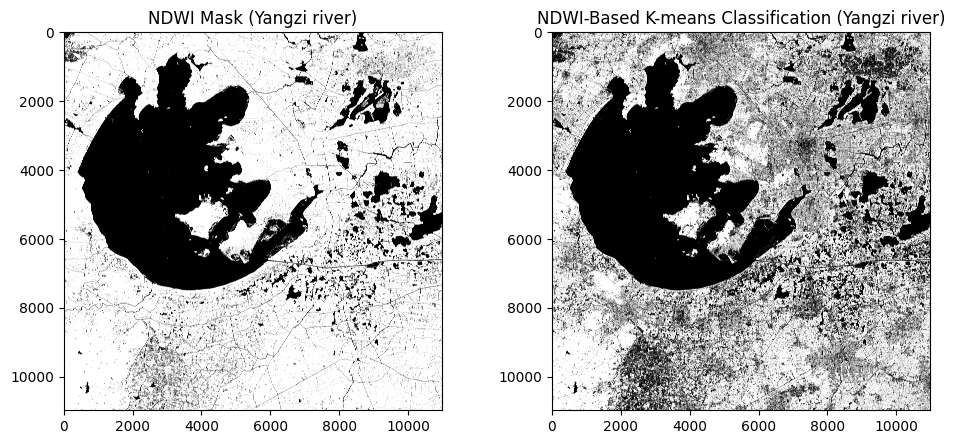

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# NDWI mask
ax1.imshow(yzr_mask_ndwi, cmap='binary', vmin=0, vmax=1)
ax1.set_title('NDWI Mask (Yangzi river)')

# Flip K-means label colors to match NDWI
yzr_labels_cleaned = np.where(yzr_labels_image_traditional == 1, 1, 0)
yzr_labels_cleaned = 1 - yzr_labels_cleaned  # <== 关键！

# K-means classification
ax2.imshow(yzr_labels_cleaned, cmap='binary', vmin=0, vmax=1)
ax2.set_title('NDWI-Based K-means Classification (Yangzi river)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()




In [41]:
ndwi_baseline_flat_yz = yzr_mask_ndwi.flatten()
kmeans_pred_flat_yz   = yzr_labels_image_traditional.flatten()


valid_mask_yz = np.isin(ndwi_baseline_flat_yz, [0, 1]) & np.isin(kmeans_pred_flat_yz, [0, 1])


ndwi_baseline_valid_yz = ndwi_baseline_flat_yz[valid_mask]
kmeans_pred_valid_yz = kmeans_pred_flat_yz[valid_mask]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96 106424512
           1       0.62      0.97      0.75  14135888

    accuracy                           0.93 120560400
   macro avg       0.81      0.94      0.86 120560400
weighted avg       0.95      0.93      0.93 120560400



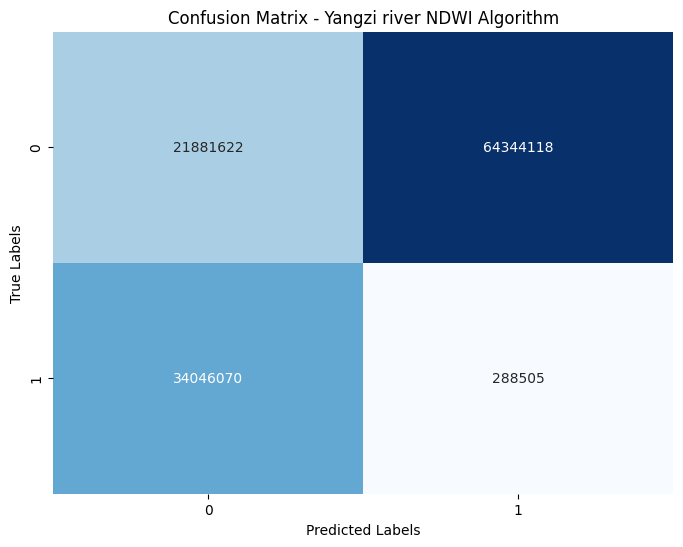

Accuracy: 0.93


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import cv2

## Data preprocessing ##

# Retrieval of values from NDWI mask (1 = water, 0 = land)
yzmask_ndwi = yzr_mask_ndwi

# Retrieval of values from K-means mask (1 = water, 0 = land, -1 = no data)
yzkmeans_results = yzr_labels_image_traditional

## Analysis calculations ##

# Flatten the 2D arrays
yzndwi_baseline = yzmask_ndwi.flatten()
yzkmeans_pred   = yzkmeans_results.flatten()

# ✅ 添加：创建掩码，排除无效像素（-1）
yzvalid_mask = np.isin(yzndwi_baseline, [0, 1]) & np.isin(yzkmeans_pred, [0, 1])
yzndwi_baseline_valid = yzndwi_baseline[yzvalid_mask]
yzkmeans_pred_valid   = yzkmeans_pred[yzvalid_mask]

# Compute confusion matrix
yzcm = confusion_matrix(yzndwi_baseline_valid, yzkmeans_pred_valid)

# Calculate accuracy
yzaccuracy = accuracy_score(yzndwi_baseline_valid, yzkmeans_pred_valid)

# Display classification report
yzreport = classification_report(yzndwi_baseline_valid, yzkmeans_pred_valid)
print("Classification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(yzcm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Yangzi river NDWI Algorithm")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display accuracy
print(f"Accuracy: {accuracy:.2f}")

#Yangzi River MNDWI

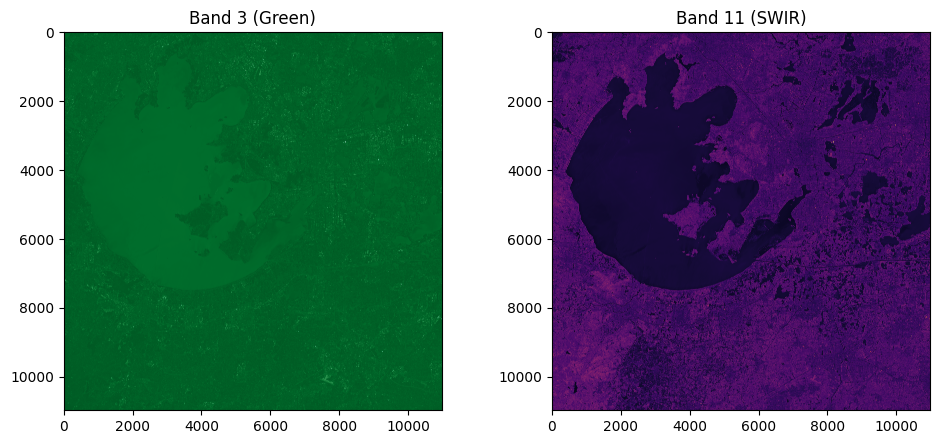

In [46]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from rasterio.enums import Resampling

yzr_bands_paths = {
    'B3': yzr_path + 'R10m/T51RTQ_20250512T023529_B03_10m.jp2',   # 10m
    'B11': yzr_path + 'R20m/T51RTQ_20250512T023529_B11_20m.jp2'   # 20m
}

yzr_band_data2 = []

# Open B3 (10m) first and get shape and profile
with rasterio.open(yzr_bands_paths['B3']) as src_b3:
    b3 = src_b3.read(1)
    ref_shape = b3.shape  # (height, width)
    ref_transform = src_b3.transform
    ref_crs = src_b3.crs
    yzr_band_data2.append(b3)

# Open B11 (20m) and resample to 10m using rasterio
with rasterio.open(yzr_bands_paths['B11']) as src_b11:
    b11_resampled = src_b11.read(
        1,
        out_shape=ref_shape,
        resampling=Resampling.bilinear
    )
    yzr_band_data2.append(b11_resampled)

# Stack to form 3D array
yzr_band_stack = np.dstack(yzr_band_data)

# Create valid mask where both bands > 0
yzr_valid_data_mask = np.all(yzr_band_stack > 0, axis=2)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(yzr_band_stack[:,:,0], cmap='BuGn_r')
ax1.set_title('Band 3 (Green)')

ax2.imshow(yzr_band_stack[:,:,1], cmap='inferno')
ax2.set_title('Band 11 (SWIR)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()


[INFO] MNDWI median: class 0 = -0.2104, class 1 = 0.2891


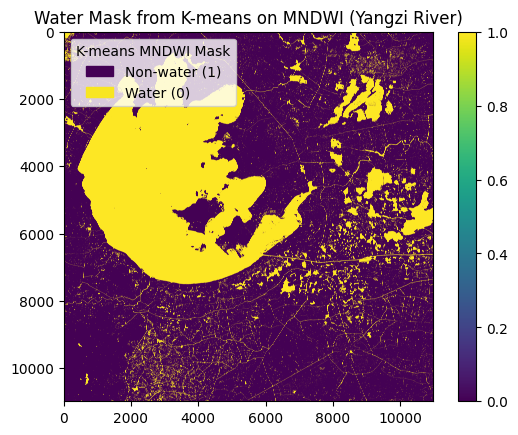

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle
import rasterio
from rasterio.enums import Resampling

# ===== 1. 读取并重采样波段（B3=Green, B11=SWIR） =====
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from rasterio.enums import Resampling

yzr_bands_paths = {
    'B3': yzr_path + 'R10m/T51RTQ_20250512T023529_B03_10m.jp2',   # 10m
    'B11': yzr_path + 'R20m/T51RTQ_20250512T023529_B11_20m.jp2'   # 20m
}

with rasterio.open(yzr_bands_paths['B3']) as src:
    yzr_ref_shape = src.read(1).shape
    yzr_ref_transform = src.transform
    yzr_ref_crs = src.crs

yzr_band_data2 = []
for band_key in ['B3', 'B11']:
    with rasterio.open(yzr_bands_paths[band_key]) as src:
        yzr_band = src.read(
            1,
            out_shape=yzr_ref_shape,
            resampling=Resampling.bilinear
        )
        yzr_band_data2.append(yzr_band)

# ===== 2. 计算 MNDWI =====
yzr_green = yzr_band_data2[0] / 10000.0
yzr_swir  = yzr_band_data2[1] / 10000.0

yzr_mndwi_index = (yzr_green - yzr_swir) / (yzr_green + yzr_swir + 1e-6)
yzr_valid_mask_mndwi = (yzr_green > 0) & (yzr_swir > 0)

# ===== 3. K-means 聚类（基于 MNDWI）=====
yzr_mndwi_features = yzr_mndwi_index[yzr_valid_mask_mndwi].reshape(-1, 1)
yzr_kmeans_mndwi = KMeans(n_clusters=2, random_state=0).fit(yzr_mndwi_features)
yzr_labels_mndwi = yzr_kmeans_mndwi.labels_

yzr_labels_image_mndwi = np.full(yzr_mndwi_index.shape, -1, dtype=int)
yzr_labels_image_mndwi[yzr_valid_mask_mndwi] = yzr_labels_mndwi

# ===== ✅ 使用 median 判断水体类 =====
yzr_median_0 = np.median(yzr_mndwi_index[yzr_labels_image_mndwi == 0])
yzr_median_1 = np.median(yzr_mndwi_index[yzr_labels_image_mndwi == 1])

print(f"[INFO] MNDWI median: class 0 = {yzr_median_0:.4f}, class 1 = {yzr_median_1:.4f}")

if yzr_median_0 > yzr_median_1:
    yzr_water_mask_mndwi = (yzr_labels_image_mndwi == 0).astype(int)
else:
    yzr_water_mask_mndwi = (yzr_labels_image_mndwi == 1).astype(int)

# ===== 4. 可视化 =====
yzr_legend_patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0)),
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.99))
]
yzr_legend_labels = ['Non-water (1)', 'Water (0)']

plt.legend(zjr_legend_patches, zjr_legend_labels, loc='upper left', title='K-means MNDWI Mask')
plt.imshow(yzr_water_mask_mndwi, cmap='viridis', vmin=0, vmax=1)
plt.title('Water Mask from K-means on MNDWI (Yangzi River)')
plt.colorbar()
plt.show()


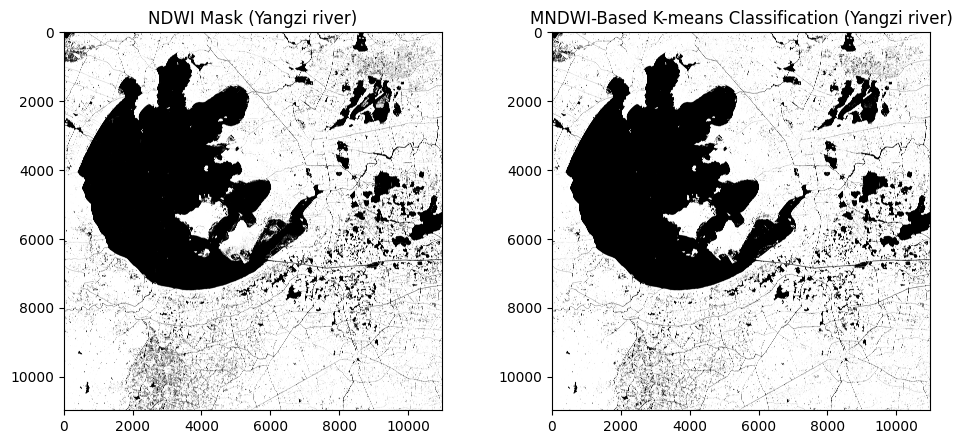

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

ax1.imshow(yzr_mask_ndwi, cmap='binary')  # Plot on the first subplot (ax1)
ax1.set_title('NDWI Mask (Yangzi river)')

ax2.imshow(yzr_water_mask_mndwi, cmap= 'binary')  # Plot on the second subplot (ax2)
ax2.set_title('MNDWI-Based K-means Classification (Yangzi river)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96 106424512
           1       0.62      0.97      0.75  14135888

    accuracy                           0.93 120560400
   macro avg       0.81      0.94      0.86 120560400
weighted avg       0.95      0.93      0.93 120560400



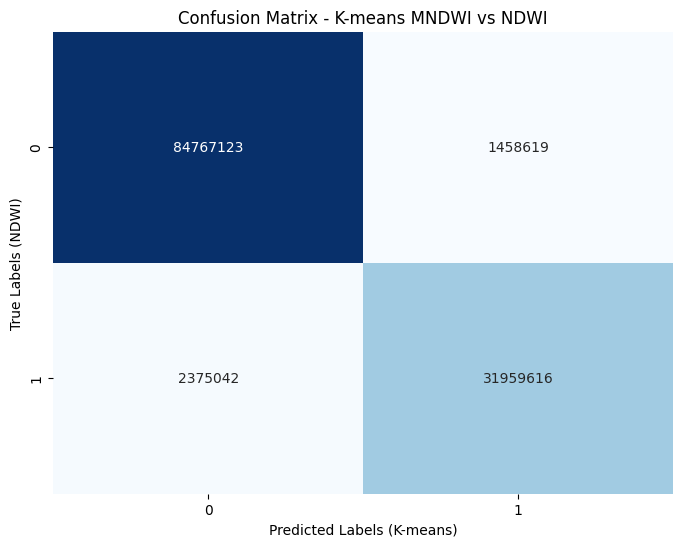

Accuracy: 0.93


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import cv2

## Data preprocessing ##

# Retrieval of values from NDWI mask (1 = water, 0 = land)
yzndwi_baseline2 = yzr_mask_ndwi.flatten()  # 举例：你实际变量名


# Retrieval of values from K-means mask (1 = water, 0 = land or -1 = invalid)
yzkmeans_pred_raw2 = yzr_water_mask_mndwi.flatten()

# ===== ✅ 1. 保留只含 0 和 1 的有效像素 =====
yzvalid_mask2 = np.isin(yzndwi_baseline2, [0, 1]) & np.isin(yzkmeans_pred_raw2, [0, 1])
yzndwi_valid2 = yzndwi_baseline2[yzvalid_mask2]
yzkmeans_valid2 = yzkmeans_pred_raw2[yzvalid_mask2]

# ===== ✅ 2. 自动反转标签（使其与 NDWI 对齐：1=water） =====
# 如果标签反了（例如预测的水体大多数被标为 0），我们可以翻转标签
conf_mat2 = confusion_matrix(yzndwi_valid2, yzkmeans_valid2)
acc_normal2 = np.trace(conf_mat2) / np.sum(conf_mat2)

# 尝试翻转预测标签
kmeans_flipped2 = 1 - yzkmeans_valid2
conf_mat_flip2 = confusion_matrix(yzndwi_valid2, kmeans_flipped2)
acc_flipped2 = np.trace(conf_mat_flip2) / np.sum(conf_mat_flip2)

# 如果翻转后准确率更高，说明标签反了 → 用翻转后的预测
if acc_flipped2 > acc_normal2:
    yzkmeans_valid2 = kmeans_flipped2
    print("[INFO] Labels were flipped to match NDWI definition (1 = water).")

# ===== 3. 输出评估指标 =====
cm3 = confusion_matrix(yzndwi_valid2, yzkmeans_valid2)
accuracy3 = accuracy_score(yzndwi_valid2, yzkmeans_valid2)
report3 = classification_report(yzndwi_valid2, yzkmeans_valid2)

print("Classification Report:\n", report)

# ===== 4. 混淆矩阵可视化 =====
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - K-means MNDWI vs NDWI")
plt.xlabel("Predicted Labels (K-means)")
plt.ylabel("True Labels (NDWI)")
plt.show()

print(f"Accuracy: {accuracy:.2f}")